## Capstone Model Building

In this third notebook we're going to use the python SKLearn library to explore a number of machine learning models, beinging with the most basic with a linear regression and moving to the more advanced methods such as gradient decent and grid search.

In [2]:
## set up packages and import saved flat file
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import seaborn as sb
import researchpy as rp
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import cross_val_predict, GridSearchCV, cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import time

In [3]:
## import our now cleaned flat file, remind ourselves what it looks like

model_data = pd.read_csv('Model_Ready_Data2.csv')
model_data.head()

,Player,Team,Year,Position,Fantasy Points,GP,TOI,IPP,SHPer,iCF,...,Weight_(lbs),Draft_Round,Round_Pick,Overall_Draft_Position,drafted,Total Minutes Played,C,D,L,R
0,Aaron Ness,NYI,2014,D,25.80,20,275.25,100.0,4.35,48,...,184,2.0,10.0,40.0,1,295.88,0,1,0,0
1,Aaron Palushaj,CAR,2014,R,0.95,2,17.52,0.0,0.00,4,...,187,2.0,14.0,44.0,1,18.65,0,0,0,1
2,Aaron Rome,DAL,2014,D,27.50,25,301.20,10.0,0.00,36,...,220,4.0,8.0,104.0,1,327.20,0,1,0,0
3,Aaron Volpatti,WSH,2014,L,32.25,41,300.18,50.0,11.11,39,...,215,100.0,100.0,1000.0,0,301.87,0,0,1,0
4,Adam Almquist,DET,2014,D,3.45,2,31.52,50.0,50.00,3,...,174,7.0,29.0,210.0,1,34.43,0,1,0,0


In [4]:
# we need to reset the index and split into target and features 
model_data.set_index(keys=['Player','Team','Year','Position'],inplace=True)
Target = model_data.iloc[:,0].values  
features = model_data.iloc[:, 1:].values 
X_train, X_test, y_train, y_test = train_test_split(features, Target, test_size=0.2, random_state=0)  

Initially we'll start with a simple linear regression, to see where we stand.

In [5]:
## linear regression
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()  
lin_reg.fit(X_train, y_train) 
print(lin_reg.intercept_)

87.15026638513251


In [6]:
y_pred = lin_reg.predict(X_test)
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df[1:20]

,Actual,Predicted
1,14.35,16.345905
2,233.65,199.122171
3,141.50,153.884527
4,185.85,200.685099
5,150.95,164.722378
6,135.25,130.762182
7,75.00,91.965383
8,158.80,176.621311
9,108.85,109.707625
10,120.45,144.194731


This is sort of goofy in that there are negative values, which I'm sure there should be some way to prevent in the code. From a glance they're low value players anyway, but it's still seems less than ideal. 

In [7]:
## looking at metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 
print('Regressor Score:',LinearRegression.score(lin_reg,X_test,  y_test))

Mean Absolute Error: 12.528943815263634
Mean Squared Error: 280.0456937924292
Root Mean Squared Error: 16.734565838181435
Regressor Score: 0.9540330384137164


That's not bad. Let's try a random forest regressor,and see what we can find as far as improvements.

In [8]:
## fitting without parameter tuning
regressor = RandomForestRegressor(n_estimators=20, random_state=0)  
regressor.fit(X_train, y_train)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Making intial predictions and charting performance

In [9]:
y_pred = regressor.predict(X_test)  
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 
print('Regreessor Score:',RandomForestRegressor.score(regressor,X_test,  y_test))

Mean Absolute Error: 11.753717660292464
Mean Squared Error: 295.7487059898763
Root Mean Squared Error: 17.19734589958219
Regreessor Score: 0.9514555313337327


That did better, but not that much better and actually dropped off at MSE.

| Metric      | Linear Regression          | Random Forest  | 
| ------------- |:-------------:| -----:| 
| Mean Absolute Error:    |  12.5 | **11.75** | 
| Mean Squared Error:    |  **280.05** | 295.75 | 
| Root Mean Squared Error:     |  16.73 | **17.2** | 
| Regressor Score:    |  0.95 | 0.95 | 

This is a fun glance at the features for the Random Forest: 

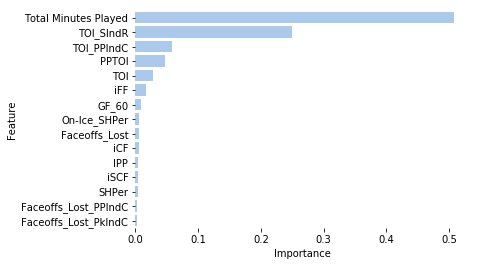

In [11]:
feature_import= list(zip(regressor.feature_importances_, model_data.columns[1:]))
feature_import = pd.DataFrame(feature_import, columns = ['Importance', 'Feature'])
top_features = feature_import.sort_values(by='Importance', ascending=False)[0:15]
# quick plot of values
sb.set_color_codes("pastel")
sb.barplot(x='Importance', y="Feature", data=top_features, color="b")
sb.despine(left=True, bottom=True)
plt.savefig('Images/features1.png', bbox_inches='tight')

Looking at features scores it's interesting that time again holds a lot of import. What I dislike here is that's not really something that we can then use as predictive value since that's a coaching decision, not a player skill.

Let's try some grid searching to see where we can find some improvements.

In [ ]:
import shap
shap.initjs()
explainer= shap.TreeExplainer(regressor)

In [24]:
explainer= shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(model_data.iloc[:, 1:])
shap.summary_plot(shap_values, model_data.iloc[:, 1:])

Exception: Length of features is not equal to the length of shap_values!

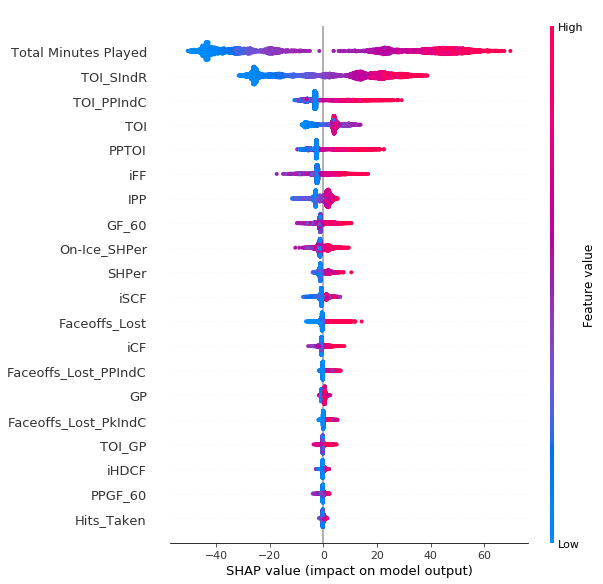

In [25]:
shap.summary_plot(shap_values, model_data.iloc[:, 1:])

In [23]:
model_data.iloc[:, 1:]

,,,,GP,TOI,IPP,SHPer,iCF,iFF,iSCF,iHDCF,Rush_Attempts,Rebounds_Created,...,Weight_(lbs),Draft_Round,Round_Pick,Overall_Draft_Position,drafted,Total Minutes Played,C,D,L,R
Player,Team,Year,Position,,,,,,,,,,,,,,,,,,,,,
Aaron Ness,NYI,2014,D,20,275.25,100.00,4.35,48,32,15,0,0,1,...,184,2.0,10.0,40.0,1,295.88,0,1,0,0
Aaron Palushaj,CAR,2014,R,2,17.52,0.00,0.00,4,4,1,1,0,0,...,187,2.0,14.0,44.0,1,18.65,0,0,0,1
Aaron Rome,DAL,2014,D,25,301.20,10.00,0.00,36,22,11,2,0,1,...,220,4.0,8.0,104.0,1,327.20,0,1,0,0
Aaron Volpatti,WSH,2014,L,41,300.18,50.00,11.11,39,27,21,9,1,5,...,215,100.0,100.0,1000.0,0,301.87,0,0,1,0
Adam Almquist,DET,2014,D,2,31.52,50.00,50.00,3,2,2,1,0,0,...,174,7.0,29.0,210.0,1,34.43,0,1,0,0
Adam Burish,S.J,2014,R,15,125.38,0.00,0.00,18,16,10,5,1,0,...,195,9.0,22.0,282.0,1,144.30,0,0,0,1
Adam Cracknell,STL,2014,R,19,151.05,33.33,0.00,28,23,13,7,0,1,...,209,9.0,21.0,279.0,1,155.45,0,0,0,1
Adam Hall,PHI,2014,R,80,544.03,53.85,4.08,86,66,42,16,3,4,...,212,2.0,24.0,52.0,1,786.40,0,0,0,1
Adam Henrique,N.J,2014,C,77,1056.60,65.00,15.31,168,133,113,59,5,14,...,197,3.0,21.0,82.0,1,1390.18,1,0,0,0


In [10]:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)


param_grid = {"max_depth": [10, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              'n_estimators':[20,50,100],
              "bootstrap": [True, False]}

# run grid search
grid_search = GridSearchCV(regressor, param_grid=param_grid, cv=5)
start = time.gmtime()
grid_search.fit(X_train,  y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.mktime(time.gmtime()) - time.mktime(start), len(grid_search.cv_results_['params'])))
grid_search.best_params_

GridSearchCV took 365.00 seconds for 108 candidate parameter settings.


{'bootstrap': False,
 'max_depth': None,
 'max_features': 10,
 'min_samples_split': 2,
 'n_estimators': 100}

In [11]:
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X_test) 

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 
print('Regressor Score:',RandomForestRegressor.score(best_grid,X_test,  y_test))

Mean Absolute Error: 11.198483689538806
Mean Squared Error: 264.4461418239595
Root Mean Squared Error: 16.261800079448754
Regressor Score: 0.9565935634351417


The grid search did improve some but not a ton across the board, other than in MSE, which makes sense as that's the metric it's scoring on.


| Metric      | Linear Regression          | Random Forest  | Grid Search  | 
| ------------- |:-------------:| -----:| -----:| 
| Mean Absolute Error:    |  12.5 | 11.75 | **11.2** | 
| Mean Squared Error:    |  280.05 | 295.75 | **264.45** | 
| Root Mean Squared Error:     |  16.73 | 17.2 | **16.26** | 
| Regressor Score:    |  0.95 | 0.95 | **0.96** | 

Again, a fun look at the important features:

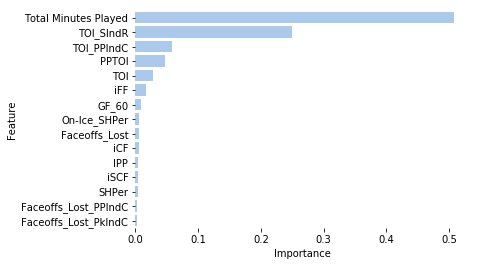

In [12]:
## checking how feature importance has changed
feature_import= list(zip(best_grid.feature_importances_, model_data.columns[1:]))
feature_import = pd.DataFrame(feature_import, columns = ['Importance', 'Feature'])
top_features_grid = feature_import.sort_values(by='Importance', ascending=False)[0:15]
# quick plot of values
sb.set_color_codes("pastel")
sb.barplot(x='Importance', y="Feature", data=top_features, color="b")
sb.despine(left=True, bottom=True)

In [13]:
## for fun I decided to re run the above using just the top 15 features, to see if triming 
## the options would reduce noise even further
feature_list = top_features_grid.Feature.unique()
trimmed_features = model_data.loc[:,feature_list].values 
trimmed_X_train, trimmed_X_test, trimmed_y_train, trimmed_y_test = train_test_split(trimmed_features, Target, test_size=0.2, random_state=0) 

In [14]:
trimmed_regressor = RandomForestRegressor(n_estimators=20, random_state=0)  
trimmed_regressor.fit(trimmed_X_train, trimmed_y_train)
# run grid search
grid_search = GridSearchCV(regressor, param_grid=param_grid, cv=5)
start = time.gmtime()
grid_search.fit(trimmed_X_train,  trimmed_y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.mktime(time.gmtime()) - time.mktime(start), len(grid_search.cv_results_['params'])))
grid_search.best_params_

GridSearchCV took 362.00 seconds for 108 candidate parameter settings.


{'bootstrap': False,
 'max_depth': None,
 'max_features': 3,
 'min_samples_split': 10,
 'n_estimators': 100}

In [15]:
best_grid = grid_search.best_estimator_
trimmed_y_pred = best_grid.predict(trimmed_X_test) 

print('Mean Absolute Error:', metrics.mean_absolute_error(trimmed_y_test, trimmed_y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(trimmed_y_test, trimmed_y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(trimmed_y_test, trimmed_y_pred))) 
print('Regressor Score:',RandomForestRegressor.score(best_grid,trimmed_X_test,  trimmed_y_test))

Mean Absolute Error: 13.700202715955148
Mean Squared Error: 400.8060463075549
Root Mean Squared Error: 20.020141016175558
Regressor Score: 0.9342113214287618


So this for me is most interesting, and a good lesson on overtuning; I thought that since the numbers are so heavily weighted on those top few metrics it would improve but in fact it dropped off significantly. Live and learn!

Let's try some gradient decent models, starting with a Gradient Boosted Regressor.

In [27]:
from sklearn import ensemble
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls', 'warm_start':'True'}
clf = ensemble.GradientBoostingRegressor(**params)

clf_pred = clf.fit(X_train, y_train).predict(X_test)


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, clf_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, clf_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, clf_pred))) 
print('Regressor Score:',LinearRegression.score(clf,X_test,  clf_pred))

In [ ]:
feature_import= list(zip(clf.feature_importances_, model_data.columns[1:]))
feature_import = pd.DataFrame(feature_import, columns = ['Importance', 'Feature'])
top_features = feature_import.sort_values(by='Importance', ascending=False)[0:15]
# quick plot of values
sb.set_color_codes("pastel")
sb.barplot(x='Importance', y="Feature", data=top_features, color="b")
sb.despine(left=True, bottom=True)
plt.savefig('Images/features2.png', bbox_inches='tight')

In [26]:
import shap
shap.initjs()
explainer= shap.TreeExplainer(clf)
shap_values = explainer.shap_values(model_data.iloc[:, 1:])
shap.summary_plot(shap_values, model_data.iloc[:, 1:])

NameError: name 'clf' is not defined

This is the first model to outperform the cross-validated Random Forest Regressor, and perhaps as interesting the first to move to Fenwick up to the top three. Time factors sill dominate but not as much.  Also perhaps the first to have to have significant improvements across the board as far as errors.


| Metric      | Linear Regression          | Random Forest  | Grid Search  | Gradient Boost  |
| ------------- |:-------------:| -----:| -----:| -----:| 
| Mean Absolute Error:    |  12.5 | 11.75 | 11.2 |  **10.13** |
| Mean Squared Error:    |  280.05 | 295.75 | 264.45 |  **209.94** | 
| Root Mean Squared Error:     |  16.73 | 17.2 | 16.26 | **14.49** | 
| Regressor Score:    |  0.95 | 0.95 | 0.96 | **1.0** |

Next we'll do a grid search on the gradient regressor.

In [ ]:
clfparam_grid = {"max_depth": [4, 10, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              'n_estimators':[500,600,700]}

# run grid search
clfgrid_search = GridSearchCV(clf, param_grid=clfparam_grid, cv=5)
start = time.gmtime()
clf_grid = clfgrid_search.fit(X_train,  y_train).predict(X_test)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.mktime(time.gmtime()) - time.mktime(start), len(clfgrid_search.cv_results_['params'])))
clfgrid_search.best_params_

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, clf_grid))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, clf_grid))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, clf_grid))) 
print('Regressor Score:',LinearRegression.score(clf,X_test,  clf_grid))

This actually performs worse than the first options. I'm thinking it's becuase I eliminated the 'none' options so I'm rerunning with that added back in. Score comparisions:

| Metric      | Linear Regression         | Grid Search  | Gradient Boost  | Grid and Gradient  |
| ------------- |-------------:| -----:| -----:| -----:| 
| Mean Absolute Error:    |  12.53 | 11.2 | **10.13** | 10.26 |
| Mean Squared Error:    |  280.05 | 264.45 | **209.94** |  220.11 |
| Root Mean Squared Error:     |  16.73 | 16.26 |  **14.49** | 14.84 |
| Regressor Score:    |  0.95 | 0.96 |  **1** | .99 |

Below we add in the none options but also squared up the number of features and max depth, making max depth the square root of each of the max features.


In [23]:

clfparam_grid2 = {"max_depth": [ None,3,  5],
              "max_features": [None, 10, 25],
              "min_samples_split": [2, 3, 10],
              'n_estimators':[500, 600] }


clfgrid_search2 = GridSearchCV(clf, param_grid=clfparam_grid2, cv=5)
start = time.gmtime()
clf_grid2 = clfgrid_search2.fit(X_train,  y_train).predict(X_test)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.mktime(time.gmtime()) - time.mktime(start), len(clfgrid_search2.cv_results_['params'])))
clfgrid_search2.best_params_



GridSearchCV took 34545.00 seconds for 54 candidate parameter settings.
'max_depth': 5, 'max_features': 25, 'min_samples_split': 2, 'n_estimators': 600}

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, clf_grid2))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, clf_grid2))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, clf_grid2))) 
print('Regressor Score:',LinearRegression.score(clf,X_test,  clf_grid2))

Mean Absolute Error: 9.24464315243264  
Mean Squared Error: 177.46336088204436  
Root Mean Squared Error: 13.321537481914179  
Regressor Score: 0.9968268291598121
    
That makes this slightly better than the others are far as MAE but dramatically better in MSE and RMSE and if you round the regressor score it's a 1

| Metric      | Linear Regression         | Grid Search  | Gradient Boost  | Gradient Grid 1  | Gradient Grid 2 |
| ------------- |-------------:| -----:| -----:| -----:| -----:| 
| Mean Absolute Error:    |  12.53 | 11.2 | 10.13 | 10.26 | **9.24** |
| Mean Squared Error:    |  280.05 | 264.45 | 209.94 |  220.11 | **177.46** |
| Root Mean Squared Error:     |  16.73 | 16.26 |  14.49 | 14.84 | **13.32** |
    | Regressor Score:    |  0.95 | 0.96 |  **1** | 0.99 |0.996|


## Conclusion

I think arguably you could run through deeper regressions with more estimators and get a a closer and closer score, but for our purposes here there's no real need. Also, you could make a decent argument that the standard Gradient Boost works just as well for the effort as going through those iterations of grid searches. 

That said, I'm happy here with the version that we found with the second grid search. Now we'll make this somewhat forward looking and see how teams in the actual fantasy league would have done with this model.
